# Objective
**Goal:** The goal for this project is to use machine learning to predict the most likely co-morbidities, given a set of medical data. In this instance, we will target leukemia and identify its co-morbidities.

Dataset: MIMIC-IV is the fourth iteration of the MIMIC medical health data repository of over 40,000 patients admitted to the Beth Israel Deaconess Medical Center (BIDMC). It was completely de-identified as of MIMIC-III with the removal of patient identifiers in accordance with the Health Insurance Portability and Accountability Act (HIPAA).

**Disclaimer:** 

The data provided in the `data/` directory is a modified version of the original, which was previously downloaded from MIMIC-IV's data repository. This was done because this data set is semi-restricted. This means that while this dataset is open to all researchers, one must first go through a credentialing process via [PhysioNet](https://physionet.org/settings/credentialing/) and signing a user agreement prior to being granted access.

The credentialing exists to educate the researcher on responsible data handling of patient health data and Health Insurance Portability and Accountability Act (HIPAA) regulations.

**All `subject_id` and `hadm_id` have been prgrammatically offset by some number to further preserve the anonymity of the patient data.**

# Demo
We will be working mainly with PySpark for this project (though it very likely can also be done using exclusively pandas or numpy).

Import Spark:

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PatientData").getOrCreate()

## PREPROCESSING THE DATA: 

Preprocessing steps:

1. Load in patient diagnoses data
2. Load in table for ICD codes, which give meaning and to the diagnoses data and helps us better target the disease we are looking for, in this case leukemia.
3. Filter the patient dataframe to include only the hospital stays (`hadm_id`) that involve leukemia, that is to say the rows that match the `icd_code` for leukemia. Save a list of these hospital stays.
4. Go through the train and validation sets and create a new 'label' column in the patient dataframe. The rows that match the `hadm_id` in the previously saved list and tag them with a 1. The rows that do not have a `hadm_id` match will be tagged with a 0, indicating that the hospital stay did not involve leukemia.

Luckily this dataset is already quite clean and organized being that it is structured data so there isn't much to do in regards to data cleansing.

## Importing the Data
import the patient data from diagnoses_icd.csv as another dataframe.

In [2]:
patients_df = spark.read.options(header='True', inferSchema='True') \
     .csv("data/diagnoses_icd_demo.csv")

Here are a few lines from the patients DataFrame:

In [3]:
patients_df.show(10)

+-------+----------+--------+-------+--------+-----------+
|    _c0|subject_id| hadm_id|seq_num|icd_code|icd_version|
+-------+----------+--------+-------+--------+-----------+
|2670103|  18648634|21909546|      2|    E861|         10|
|2670104|  18648634|21909546|      5|  O99512|         10|
|2670105|  18648634|21909546|      6|  J45909|         10|
|2670106|  18648634|21909546|      1|  O99612|         10|
|2670107|  18648634|21909546|      7|  O99282|         10|
|2670108|  18648634|21909546|      4|    R931|         10|
|2670109|  18648634|21909546|      3|    A084|         10|
|2782876|  11896075|21596984|      1|   O4292|         10|
|2782877|  11896075|21596984|      6|   Z3A40|         10|
|2782878|  11896075|21596984|      2|    E039|         10|
+-------+----------+--------+-------+--------+-----------+
only showing top 10 rows



Here is the schema for reference:

In [4]:
patients_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- subject_id: integer (nullable = true)
 |-- hadm_id: integer (nullable = true)
 |-- seq_num: integer (nullable = true)
 |-- icd_code: string (nullable = true)
 |-- icd_version: integer (nullable = true)



# Overview of the Data

Directly from MIMIC-IV's documentation for diagnoses_icd.csv:

## Detailed Description

### `subject_id`

subject_id is a unique identifier which specifies an individual patient. Any rows associated with a single subject_id pertain to the same individual.

### `hadm_id`

hadm_id is an integer identifier which is unique for each patient hospitalization.

### `seq_num`

The priority assigned to the diagnoses. The priority can be interpreted as a ranking of which diagnoses are “important”, but many caveats to this broad statement exist. For example, patients who are diagnosed with sepsis must have sepsis as their 2nd billed condition. The 1st billed condition must be the infectious agent. There’s also less importance placed on ranking low priority diagnoses “correctly” (as there may be no correct ordering of the priority of the 5th - 10th diagnosis codes, for example).

### `icd_code, icd_version`

icd_code is the International Coding Definitions (ICD) code.

source: https://mimic-iv.mit.edu/docs/datasets/hosp/diagnoses_icd/

There are two versions for this coding system: version 9 (ICD-9) and version 10 (ICD-10). These can be differentiated using the icd_version column. In general, ICD-10 codes are more detailed, though code mappings (or “cross-walks”) exist which convert ICD-9 codes to ICD-10 codes.

Both ICD-9 and ICD-10 codes are often presented with a decimal. This decimal is not required for interpretation of an ICD code; i.e. the icd_code of ‘0010’ is equivalent to ‘001.0’.

There exists both ICD 9 and ICD 10 codes within the dataset. However, in this demo, I filtered out the ICD 9 data. While the reduction in data could potentially negatively affect the results, the act of including all the ICD 9 data may increase project runtime, computational resources, and complexity.

Since this is mostly a proof of concept, I will filter the table down to only rows that contain ICD 10 codes.

In the case that you do run into a dataset that contains multiple ICD code versions, filter it down like so.

In [8]:
icd_10_patients_df = patients_df.filter(patients_df.icd_version == 10)
icd_10_patients_df.show(10)

+-------+----------+--------+-------+--------+-----------+
|    _c0|subject_id| hadm_id|seq_num|icd_code|icd_version|
+-------+----------+--------+-------+--------+-----------+
|2670103|  18648634|21909546|      2|    E861|         10|
|2670104|  18648634|21909546|      5|  O99512|         10|
|2670105|  18648634|21909546|      6|  J45909|         10|
|2670106|  18648634|21909546|      1|  O99612|         10|
|2670107|  18648634|21909546|      7|  O99282|         10|
|2670108|  18648634|21909546|      4|    R931|         10|
|2670109|  18648634|21909546|      3|    A084|         10|
|2782876|  11896075|21596984|      1|   O4292|         10|
|2782877|  11896075|21596984|      6|   Z3A40|         10|
|2782878|  11896075|21596984|      2|    E039|         10|
+-------+----------+--------+-------+--------+-----------+
only showing top 10 rows



## Importing ICD code definitions
- load in the table
- filter the table to ICD 10 codes
- extract a list of codes that specifically refer to our target diagnosis, leukemia

In [9]:
diagnoses_def_df = spark.read.options(header='True', inferSchema='True') \
     .csv("data/d_icd_diagnoses.csv")

Since we are only use ICD 10 codes, we can also filter this table down:

In [87]:
diagnoses_icd_10_def = diagnoses_def_df.filter(
    diagnoses_def_df.icd_version == 10
)

diagnoses_icd_10_def = diagnoses_icd_10_def \
.withColumnRenamed("long_title", "definition")

Here is one example of an ICD code definition:

In [88]:
diagnoses_icd_10_def.head()

Row(icd_code='B5741', icd_version=10, definition="Meningitis in Chagas' disease")

Now, let's search for a disease (or diseases) that we want to focus on.

In this case, we are selecting leukemia as our target diagnosis.

Import the d_icd_diagnoses.csv as a dataframe and find the icd_codes that include references to 'leukemia' or 'leukemic':

In [12]:
# Get codes for our desired diagnosis or disease
leukemia_codes_df = diagnoses_icd_10_def.filter(
    diagnoses_icd_10_def.long_title.contains('leukemia') |
    diagnoses_icd_10_def.long_title.contains('leukemic')
) \
.select('icd_version', 'icd_code') \
.orderBy('icd_version') \
.distinct()

In [13]:
leukemia_codes_df.show(10)
print("There are",leukemia_codes_df.count(), "codes relating to leukemia.")

+-----------+--------+
|icd_version|icd_code|
+-----------+--------+
|         10|   C93Z1|
|         10|    C951|
|         10|   C9111|
|         10|    C914|
|         10|   C9310|
|         10|    C929|
|         10|   C9102|
|         10|   C91Z0|
|         10|   C9130|
|         10|    C911|
+-----------+--------+
only showing top 10 rows

There are 126 codes relating to leukemia.


Save these codes as a Python list:

In [14]:
leukemia_codes = leukemia_codes_df.select("icd_code").collect()

leukemia_codes_list = [row[0] for row in leukemia_codes]
print(leukemia_codes_list)

['C93Z1', 'C951', 'C9111', 'C914', 'C9310', 'C929', 'C9102', 'C91Z0', 'C9130', 'C911', 'C9252', 'C91', 'C92Z1', 'C9110', 'C9132', 'C933', 'C9202', 'C92A1', 'C9161', 'C9152', 'C924', 'C9421', 'C9151', 'C9261', 'C92A', 'C9190', 'C9011', 'C931', 'C91Z2', 'C93Z', 'C9302', 'C9250', 'C9332', 'C9301', 'C9311', 'C9012', 'C9131', 'C9150', 'C9210', 'C922', 'C919', 'C9221', 'C9262', 'C9220', 'C9100', 'C9212', 'C9420', 'C92', 'C91Z1', 'C9160', 'C940', 'C901', 'C9312', 'C9400', 'C925', 'C9241', 'C9010', 'C910', 'C9292', 'C9201', 'C91A1', 'C930', 'C9290', 'C93', 'C921', 'C9242', 'C9402', 'C926', 'C9200', 'C94', 'C92Z2', 'C92A2', 'C92Z0', 'C9141', 'C92Z', 'C9391', 'C9260', 'C9422', 'C920', 'C9331', 'C9501', 'C9481', 'C9192', 'C91A0', 'C9510', 'C91A2', 'C948', 'C9191', 'C9502', 'C9511', 'C913', 'C9432', 'C9251', 'C939', 'C9140', 'C950', 'C91A', 'C93Z2', 'C943', 'C915', 'C9300', 'C9330', 'Z856', 'C9392', 'C9512', 'C9240', 'C9431', 'C9480', 'Z806', 'C9112', 'C92A0', 'C916', 'C9430', 'C9482', 'C9222', 'C

Now, extract hospital stay IDs that contain these codes from the original patient dataframe:

In [15]:
import pyspark.sql.functions as F

# filter DF to only have hadm_id's related to leukemia
hadm_id_df = icd_10_patients_df.filter(
    F.col("icd_code").isin(leukemia_codes_list))

# Return the rows
hadm_ids = hadm_id_df.select("hadm_id").collect()

# extract hadm_id from rows
hadm_ids_list = [row[0] for row in hadm_ids]

In [16]:
from pyspark.sql.functions import udf
from pyspark.sql import types as T

# UDF to tag row, based on match with hadm_id
def setIdLabels(match_list, hadm_id):
    if hadm_id in match_list:
        return "true"
    else:
        return "false"

setIdLabelsUDF = udf(lambda x: setIdLabels(hadm_ids_list, x))

In [17]:
# adding a column "match" to designate if hospital stay involved leukemia
patients_df_tagged = icd_10_patients_df.withColumn(
    "match",
    setIdLabelsUDF(icd_10_patients_df.hadm_id)
)

In [18]:
# proof the labeling worked
patients_df_tagged.filter(patients_df_tagged.match == "true").show(10)

+-------+----------+--------+-------+--------+-----------+-----+
|    _c0|subject_id| hadm_id|seq_num|icd_code|icd_version|match|
+-------+----------+--------+-------+--------+-----------+-----+
|2984586|  19685388|20658431|      1|   C9152|         10| true|
|2984587|  19685388|20658431|     24|   R1310|         10| true|
|2984588|  19685388|20658431|     29| T17998A|         10| true|
|2984589|  19685388|20658431|     16|     R21|         10| true|
|2984590|  19685388|20658431|     26|    Z781|         10| true|
|2984591|  19685388|20658431|     21|   E8351|         10| true|
|2984592|  19685388|20658431|      2|   J9601|         10| true|
|2984593|  19685388|20658431|     19|    R531|         10| true|
|2984594|  19685388|20658431|      5|    K521|         10| true|
|2984595|  19685388|20658431|      4|  D61818|         10| true|
+-------+----------+--------+-------+--------+-----------+-----+
only showing top 10 rows



## Machine Learning

Recalling the problem statement and overview of procedures, I would like to predict the subset of comorbidities given that a patient has leukemia. For this I implement a logistic regression model.

### Preprocessing Continued

We need to do some feature engineering to establish our dependent and independent variables.

The only variable(s) that matter are `seq_num` and `icd_code`. 

`subject_id`, `hadm_id`, and `icd_version` imbue no meaningful information since each subject and hospital admission is unique and are not useful in determining the probability of a comorbidity.

Therefore, these columns will not be considered in engineering the `features` vector.

In [19]:
from pyspark.ml.feature import RFormula

# Feature engineering
rf = RFormula(formula="match ~ seq_num + icd_code")  # Defining the transformation
fittedRF = rf.fit(patients_df_tagged)  # Create "trained" version of transformer to use on data

# Apply transformations patient df
prepared_patient_df = fittedRF.transform(patients_df_tagged)

Here is the dataframe with feature vectors for each row:

In [20]:
prepared_patient_df.select(
    "seq_num",
    "icd_code",
    "match",
    "label",
    "features").show(10,False)

+-------+--------+-----+-----+--------------------------+
|seq_num|icd_code|match|label|features                  |
+-------+--------+-----+-----+--------------------------+
|2      |E861    |false|0.0  |(12581,[0,100],[2.0,1.0]) |
|5      |O99512  |false|0.0  |(12581,[0,2951],[5.0,1.0])|
|6      |J45909  |false|0.0  |(12581,[0,15],[6.0,1.0])  |
|1      |O99612  |false|0.0  |(12581,[0,3168],[1.0,1.0])|
|7      |O99282  |false|0.0  |(12581,[0,3961],[7.0,1.0])|
|4      |R931    |false|0.0  |(12581,[0,3616],[4.0,1.0])|
|3      |A084    |false|0.0  |(12581,[0,407],[3.0,1.0]) |
|1      |O4292   |false|0.0  |(12581,[0,919],[1.0,1.0]) |
|6      |Z3A40   |false|0.0  |(12581,[0,269],[6.0,1.0]) |
|2      |E039    |false|0.0  |(12581,[0,13],[2.0,1.0])  |
+-------+--------+-----+-----+--------------------------+
only showing top 10 rows



Now that the dataset is vectorized, I split the data into training and testing sets using `df.randomSplit()`.

In [21]:
# Create train, validation, and test splits
train, test = prepared_patient_df.randomSplit(
    [0.7,0.3],30  # specify a seed as to maintain the same datasets
)

Instantiate the LogisticRegression model:

In [22]:
from pyspark.ml.classification import LogisticRegression

# Logical Regression
lr = LogisticRegression(labelCol="label",featuresCol="features")

fittedLR = lr.fit(train)  # Trained model

Train the model using the training set:

In [23]:
trainedLR = fittedLR.transform(train).select("label", "prediction")

Run the test set through the trained model:

In [24]:
testLR = fittedLR.transform(test).select(
    "icd_code",
    "label",
    "rawPrediction",
    "prediction",
    "probability"
)

In [25]:
print("Logistical Regression on Test dataset")
print("displaying codes that are predicted to appear alongside leukemia:")
testLR.filter(testLR.prediction == 1).show(10)

Logistical Regression on Test dataset
displaying codes that are predicted to appear alongside leukemia:
+--------+-----+--------------------+----------+--------------------+
|icd_code|label|       rawPrediction|prediction|         probability|
+--------+-----+--------------------+----------+--------------------+
|   C9152|  1.0|[-48.385491040684...|       1.0|[9.69277735118441...|
|   C9200|  1.0|[-48.394986745827...|       1.0|[9.60117320673481...|
|    Z574|  1.0|[-0.1130870783122...|       1.0|[0.47175832184120...|
|   C9202|  1.0|[-48.435391869833...|       1.0|[9.22096942762875...|
|   C9110|  1.0|[-48.671647940868...|       1.0|[7.28067883917669...|
|   G5700|  1.0|[-0.4082706884934...|       1.0|[0.39932685000670...|
|   C9110|  1.0|[-48.445097919420...|       1.0|[9.13190318105168...|
|    T865|  0.0|[-0.1966090576413...|       1.0|[0.45100545816875...|
|   C9210|  1.0|[-48.569026296151...|       1.0|[8.06751698027508...|
|    T865|  0.0|[-0.2872290662204...|       1.0|[0.42868

- I chose to only display only rows where a prediction of 1 was made
- this was done to demonstrate that the ML model successfully (and unsuccessfully) made predictions.
- If the displayed DF was left unfiltered, we would only see labels = 0 and predictions = 0 because most of the beginning rows of the dataset were icd_codes that were unrelated to leukemia.

Here is what I mean:

In [26]:
testLR.show(10)

+--------+-----+--------------------+----------+--------------------+
|icd_code|label|       rawPrediction|prediction|         probability|
+--------+-----+--------------------+----------+--------------------+
|  O99512|  0.0|[12.4188894259139...|       0.0|[0.99999595849522...|
|  J45909|  0.0|[4.42854138208608...|       0.0|[0.98820881003454...|
|  O99612|  0.0|[12.5594053902364...|       0.0|[0.99999648829506...|
|  O99282|  0.0|[12.6394637151133...|       0.0|[0.99999675847596...|
|   O4292|  0.0|[12.3554210707667...|       0.0|[0.99999569367367...|
|  O99280|  0.0|[4.83194347050875...|       0.0|[0.99209201985603...|
|  Z85828|  0.0|[3.64817034034879...|       0.0|[0.97462208146871...|
| O321XX0|  0.0|[12.6290022248211...|       0.0|[0.99999672438690...|
|   O1092|  0.0|[12.4051013330452...|       0.0|[0.99999590238487...|
|    Z370|  0.0|[7.3103184428681,...|       0.0|[0.99933184262680...|
+--------+-----+--------------------+----------+--------------------+
only showing top 10 

## Evaluating the model

To evaluate the model, we utilize `BinaryClassificationEvaluator` from `pyspark.ml` library. The evaluator evaluates the model by plotting events of True Positive Rate (TPR) against False Positive Rate (FPR).

This evaluation results in an Receiver Operating Characteristics (ROC) curve, which can be plotted like so:

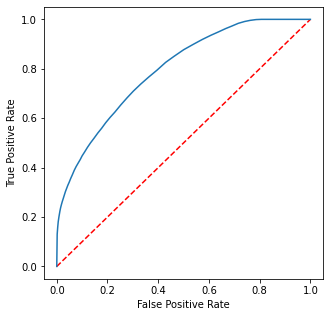

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fittedLR.summary.roc.select('FPR').collect(),
         fittedLR.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The greater the area under the ROC curve, the better the model is at discerning whether a disease has shown up alongside leukemia.

In [28]:
summary = fittedLR.summary
print("Area under ROC for model:", summary.areaUnderROC)

Area under ROC for model: 0.7947841669310771


We can also get the area under ROC of our test data fed into the model.

In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC:", evaluator.evaluate(testLR))

Test Area Under ROC: 0.7054346516722116


Calculating model accuracy:

In [30]:
accuracy = testLR.filter(
    testLR.label == testLR.prediction).count() / float(testLR.count())

print("Accuracy:", accuracy)

Accuracy: 0.9806108473338203


After calculating the model's accuracy, we should extract all of the `icd_codes` from the test dataset, because these will be our leukemia co-morbidities. Save this as a new dataframe.

This is to simulate the results of a true test dataset (as opposed to our test set that had rows labeled already to check our accuracy).

In [37]:
# Extracting leukemia comorbidities from test data
leukemia_comorbidities_df = testLR \
.filter(testLR.prediction == 1) \
.select(testLR.icd_code)

leukemia_comorbidities_df.show(10)

+--------+
|icd_code|
+--------+
|   C9152|
|   C9200|
|    Z574|
|   C9202|
|   C9110|
|   G5700|
|   C9110|
|    T865|
|   C9210|
|    T865|
+--------+
only showing top 10 rows



Let's aggregate the codes such that we get a count of each.

This will help us see which conditions are most prevalent.

In [45]:
from pyspark.sql.functions import desc

diagnoses_count = leukemia_comorbidities_df.groupBy('icd_code').count()
diagnoses_count = diagnoses_count.sort(desc('count'))
diagnoses_count.show()

+--------+-----+
|icd_code|count|
+--------+-----+
|   C9110|   67|
|    T865|   47|
|  D89811|   36|
|   C9200|   34|
|    Z856|   23|
|   C9201|   23|
|    Z806|   19|
|   C9202|   15|
|   C9210|   14|
|   C92Z0|   10|
|  D89813|    9|
|    D708|    8|
|    H209|    7|
|  D89810|    7|
|   C92Z2|    6|
|   K1230|    5|
|   C9211|    5|
|   C9010|    4|
|   C92Z1|    4|
|   C9111|    4|
+--------+-----+
only showing top 20 rows



However, this joined table still includes the `icd_codes` that explicitly refer to leukemia. 

We want to remove these specific because we only want co-morbidities.

Therefore, I will filter them out.

In [50]:
# filter out icd_codes that directly reference leukemia
comorbidities_filtered = diagnoses_count \
.filter(diagnoses_count.icd_code.isin(leukemia_codes_list) == False)

comorbidities_filtered.show()

+--------+-----+
|icd_code|count|
+--------+-----+
|    T865|   47|
|  D89811|   36|
|  D89813|    9|
|    D708|    8|
|  D89810|    7|
|    H209|    7|
|   K1230|    5|
|   R5081|    3|
|    L740|    3|
|  I70492|    3|
|    D709|    2|
|    K045|    2|
|   C8410|    2|
|    L729|    2|
|  D89812|    2|
|    Z574|    2|
| S42201D|    2|
|    D703|    2|
|   T8609|    2|
|    I809|    2|
+--------+-----+
only showing top 20 rows



Then, create an inner join between this table and the icd-definitions table to better visualize which diseases/diagnoses often appear with leukemia. This will give us icd_code definitions.

In [91]:
comorbidities_with_def = comorbidities_filtered \
.join(diagnoses_icd_10_def, ['icd_code']) \  # left inner join by default
.sort(desc('count'))

DataFrame[icd_code: string, count: bigint, icd_version: int, definition: string]

In [93]:
# Number of distinct comorbidities, given the test set
comorbidities_with_def.count()

52

Here are the most common codiagnoses found with "leukemia" (found within the test data set).

In [101]:
top_comorbidities = comorbidities_with_def.filter(F.col("count") > 5)
top_comorbidities.show()

+--------+-----+-----------+--------------------+
|icd_code|count|icd_version|          definition|
+--------+-----+-----------+--------------------+
|    T865|   47|         10|Complications of ...|
|  D89811|   36|         10|Chronic graft-ver...|
|  D89813|    9|         10|Graft-versus-host...|
|    D708|    8|         10|   Other neutropenia|
|  D89810|    7|         10|Acute graft-versu...|
|    H209|    7|         10|Unspecified irido...|
+--------+-----+-----------+--------------------+



Plot this data as a bar graph:

In [102]:
top_pd = top_comorbidities.toPandas()

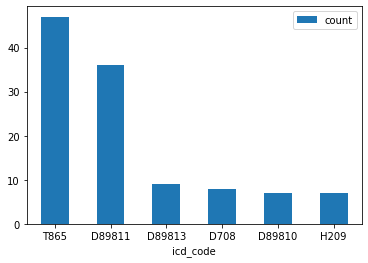

In [103]:
ax = top_pd.plot.bar(x='icd_code', y='count', rot=0)

Finally, we can export the table of comorbidities as a .csv file for future reference.

In [95]:
comorbidities_pd_df = comorbidities_with_def.toPandas()

In [96]:
comorbidities_pd_df.to_csv('leukemia_codiagnoses.csv')

## Summary

Via the Pyspark.ml library, we were able to train a logistic regression model that is able to produce a subset of co-diagnoses based on International Coding Definitions (ICD) codes, given a robust training set and a precise target diagnosis. Here, we used the target diagnosis of leukemia. The most common ones involved stem cell transplant complications and graft complications (like graft-versus-host disease).

This makes sense because bone marrow (stem cell) transplants are a common treatment to fight leukemia. However, it is an invasive and painful procedure that can result in complications for the patient.

## Challenges/Limitations
- The model is only as good as the available data
    - It's possible the prediction accuracy is only high because the test set is a subset of the training set (despite technically never seeing the test set)
    - The data is reflective of patients of a certain population demographic. There is no guarantee that this model will reliably predict a different set of patient data
- The model may work better for certain target disease than others
    - for example, some diseases have very common and clear-cut co-diagnoses (think COVID-19 and pneumonia and lung tissue scarring), while others are not so clear

## Future Considerations
- It would be interesting to see how this model would improve or worsen if given a larger, broader set of patient data
- the overall accuracy for specific demographics may potentially decrease because the model was exposed to so many geographical demographics
- on the other hand, model as a whole might be more accurate for a diverse population since it it's less specialized for one specific demographic

### References:
MIMIC-IV Dataset and Documentation:

https://mimic-iv.mit.edu
https://mimic-iv.mit.edu/docs


Pyspark BinaryClassifcation Evaluator:

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html

Overview of Leukemia and Common Treatments:

https://www.mayoclinic.org/diseases-conditions/leukemia/diagnosis-treatment/drc-20374378